# Exercise: Weather API

## Aim: Use a Weather API to create and graph NetCDF files

### Issues covered:

- Request and get data from a weather API service
- Read and retrieve information from a JSON response
- Write contents to a NetCDF file
- Read a collection of NetCDF files and plot a time series graph

## 1. Let's get data from a web API on the internet

We will use the NOAA National Weather Service in the US as our data source:

![](https://www.weather.gov/css/images/header.png)

The service has a web API that allows you to request forecast data for a given grid point in the USA. Details of the API are documented at:

https://www.weather.gov/documentation/services-web-api

Use the endpoint `https://api.weather.gov/` as the base URL.

Firstly, we want to get a grid ID and based on some latitude/longitude coordinates. To do so we will use the `points/{latitude,longitude}` endpoint of the API.

**Choose the latitude and longitude of your favourite US location (this API is US only and in latitude North, longitude East). The extent of the USA is approximately:**
- Longitude: -120, -80
- Latitude:  30, 48

Once you have queried the `points` API you will get back a `grid ID` (`GridId`). The `grid ID`h can be used to get a weather forecast for your location of interest, using the `gridpoints/{grid ID}/{grid co-ordinates}` endpoint.

Import the `requests` library which is great for downloading content from external URLs.

In [52]:
import requests

You can use the requests library to access the web API. Fill in the elipses with the `latitude` (degrees North) and `longitude` (degrees East, so use negative value) of a location in the US. 
If successful, the response code should be 200.

In [53]:
url = 'https://api.weather.gov/'
latitude = 40
longitude = -100

# Hint: use the requests library to GET from the url: https://api.weather.gov/points/{LAT},{LON}
response = requests.get(f'{url}points/{latitude},{longitude}')
response.status_code

200

With the requests library, the results from the webAPI can be extracted into in JSON format. A JSON document behaves exactly like a dictionary.

Use dictionary indexing to extract the values of the grid ID and the X/Y coordinates:

- get `gridID`
- get `gridX`
- get `gridY`

In [54]:
# hint: you can view the JSON by pasting the URL directly into your browser address bar

response = response.json()

gridID = response['properties']['gridId']
gridX = response['properties']['gridX']
gridY = response['properties']['gridY']

With your `gridID`, `gridX`, and `gridY`, use the `gridpoints` API endpoint to request a weather forecast for that location. Print the status code.
If everything is working, you should get another 200 status code.

In [55]:
response = requests.get(f'{url}gridpoints/{gridID}/{gridX},{gridY}')
response.status_code

200

Can you use the JSON response data to get the forecast temperature values? Use dictionary indexing to get the `values` from `temperature` in `properties`.

In [56]:
data = response.json()
forecast = data['properties']['temperature']['values']

The below code extracts the coordinates of the grid box you have chosen.

In [57]:
coords = data['geometry']['coordinates'][0][0]
x = coords[1]
y = coords[0]

## 2. Let's format that data and write it to NetCDF

### Formatting the data

First, format your forecast data to get the datetime and air temperature as separate
lists.

In [58]:
from datetime import datetime as dt

Loop through your `forecast` values and get the temperatures (`value`) and datetimes (`validTime`) into a list.
`forecast` is a list of dictionaries, where each dictionary is of one time instance.
Fill in the ellipses to format each `validTime` string to a python `datetime` object and assign and set to the variable `date`. Get each `value` and assign to the variable `temp`. These values will then be appended to the `temps` and `timeseries` lists.

In [59]:
# Use the datetime module to convert the times from the data to a datetime object.
# Hint: look at the validTime string and see how you can turn the string to datetime
# using strptime, the format of the datetime is: '%Y-%m-%dT%H:%M:%Sz'.

timeseries = []
temps = []

for item in forecast:
    
    date = item['validTime']
    date = dt.strptime(date.split('/')[0], '%Y-%m-%dT%H:%M:%S%z')
    timeseries.append(date)
    
    temp = item['value']
    temps.append(temp)

Format the `timeseries` list and convert it to relative time in seconds from the start of the timeseries. When using NetCDF and the CF Metadata Conventions time is stored as an offset from a base time rather than an absolute times.

If you are stuck, take look at the 'Time series' slide in the [logging data from serial ports](https://github.com/ncasuk/ncas-isc/raw/68abbfd3a573e576c32fc127fafc874bfff98b1e/python/presentations/logging-data-from-serial-ports/LDFSP_Slides.pdf) presentation.

In [60]:
base_time = timeseries[0]
time_values = []

for t in timeseries:
    value = t - base_time
    ts = value.total_seconds()
    time_values.append(ts)

time_units = "seconds since " + base_time.strftime('%Y-%m-%d %H:%M:%S')

time_units

'seconds since 2023-11-17 05:00:00'

Convert the `temps` list from degrees C to Kelvin. As per the CF Conventions, the canonical units for Air Temperature is K. Create a new list, called `temp_values`, which is the temperature in Kelvin.

In [61]:
temp_values = []

for t in temps:
    t = t + 273.15
    temp_values.append(t)

### Create a netCDF4 Dataset and write the contents to a file

Import the `Dataset` class from the `netCDF4` library. You can go on to create an *instance* of this class which will contain:
- variables
- coordinate variables
- dimensions
- global attributes

When you create the instance of `Dataset`, you will give it a file name which will be written to when you close the `Dataset`.

Also import `numpy` as `np`. This will be used to construct the data arrays from the existing lists that currently hold the weather data and coordinate information.


In [62]:
from netCDF4 import Dataset
import numpy as np

#### Quick aside, let's make sure we have a `DATA_DIR` to write to

Since this is a group exercise, everyone should be writing to the same output directory. Let's set some python variables that can be used below:
1. `USER` - used in the output file names to ensure every NetCDF file is unique.
2. `HOME_DIR` - your `$HOME` directory
2. `MY_DATA_DIR` - the directory where you will write your NetCDF file.
3. `GROUP_DATA_DIR` - the directory where all the NetCDF files will eventually be collected/available.

Since `GROUP_DATA_DIR` is not writeable directly from the Notebook Service, we have set up a job to replicate files from `MY_DATA_DIR` to `GROUP_DATA_DIR` (which runs once per minute).

In [63]:
import os
USER = os.environ["JUPYTERHUB_USER"]

HOME_DIR = f"/home/users/{USER}"
MY_DATA_DIR = os.path.join(HOME_DIR, "weather-api-outputs")

# Create MY_DATA_DIR if it doesn't exist
if not os.path.isdir(MY_DATA_DIR):
    os.mkdir(MY_DATA_DIR)

# All NetCDF will be automatically copied here (once per minute)
GROUP_DATA_DIR = "/gws/pw/j07/workshop/weather-api-data"

# The output file will initially be written to your HOME_DIR (then you will move
# it when complete)
filename = f"{gridID}-{USER}-temps.nc"
outfile = f"{HOME_DIR}/{filename}"

#### Back to our NetCDF file

Create the output file, as a `netCDF4 Dataset` instance, using the `outfile` defined above.

If you need help, have a look at the 'Create the NetCDF dimensions & variables' slide in the [logging data from serial ports](https://github.com/ncasuk/ncas-isc/raw/68abbfd3a573e576c32fc127fafc874bfff98b1e/python/presentations/logging-data-from-serial-ports/LDFSP_Slides.pdf) presentation.

In [67]:
try:
    dataset = Dataset(outfile, "w", format="NETCDF4_CLASSIC")
except PermissionError:
    print('ahhhhhhhhh run away')

ahhhhhhhhh run away


#### Start by defining some dimensions

Create NetCDF *dimensions*:
- `time_dim`: *unlimited* length
- `lat_dim`: length 1
- `lon_dim`: length 1

In [68]:
time_dim = dataset.createDimension('time', None)
lat_dim = dataset.createDimension('lat', 1)
lon_dim = dataset.createDimension('lon', 1)

RuntimeError: NetCDF: NC_UNLIMITED size already in use

#### Now define the coordinate variables and then temperature variable

Create the `time` *variable* with the following properties:
- type: numpy float (`np.float64`)
- variable id: `time`
- dimensions: (`time`,)
- set the array using the `time_values` list
- `units`: `time_units` defined earlier
- `standard_name`: `time`
- `calendar`: `standard`

In [70]:
time_var = dataset.createVariable('time', np.float64, ('time',))
time_var[:] = time_values
time_var.units = time_units
time_var.standard_name = 'time'
time_var.calendar = 'standard'

RuntimeError: NetCDF: String match to name in use

Create the `lat` *variable* with the following properties:
- type: numpy float (`np.float64`)
- variable id: `lat`
- dimensions: (`lat`,)
- set the array of length 1 using the `gridY` value
- `units`: `degrees_north`
- `standard_name`: `latitude`

In [71]:
lat_var = dataset.createVariable('lat', np.float64, ('lat',))
lat_var[:] = [gridY]
lat_var.units = 'degrees_north'
lat_var.standard_name = 'latitude'

RuntimeError: NetCDF: String match to name in use

Create the `lon` *variable* with the following properties:
- type: numpy float (`np.float64`)
- variable id: `lon`
- dimensions: (`lon`,)
- set the array of length 1 using the `gridX` value
- `units`: `degrees_east`
- `standard_name`: `longitude`

In [72]:
lon_var = dataset.createVariable('lon', np.float64, ('lon',))
lon_var[:] = [gridX]
lon_var.units = 'degrees_east'
lon_var.standard_name = 'longitude'

RuntimeError: NetCDF: String match to name in use

Create the `temp` *variable* with the following properties:
- type: numpy float (`np.float64`)
- variable id: `temp`
- dimensions: (`time`,)
- set the array using the `temp_values` list
- `long_name`: `air temperature (K)`
- `units`: `K`
- `standard_name`: `air_temperature`
- `coordinates`: `lon lat` - to relate the longitude and latitude to this variable

In [73]:
temp_var = dataset.createVariable('temp', np.float32, ('time',))
temp_var[:] = temp_values
temp_var.var_id = 'temp'
temp_var.long_name = 'Air Temperature (K)'
temp_var.units = 'K'
temp_var.standard_name = 'air_temperature'
temp_var.coordinates = 'lon lat'

RuntimeError: NetCDF: String match to name in use

#### Add some global attributes

The [CF Metadata Conventions](https://cfconventions.org/cf-conventions/cf-conventions.html#_overview) recommends a set of global attributes to "provide human readable documentation of the file contents":
- title
- history
- institution
- source
- references
- comment

Add each of the above to your `Dataset` instance. Here are some suggested values (but you can say whatever you like):
- title: Air Temperature forecasts for `<gridID>`
- history: File created on: `<YYYY-MM-DD>`
- institution: NCAS-ISC
- source: NOAA Weather API Service
- references: https://www.weather.gov/documentation/services-web-api
- comment: The ISC course is teaching me about Python and NetCDF!

You can add any other global attributes that you wish to.

In [74]:
dataset.title = f'Air Temperature forecasts for {gridID}'
dataset.history = f'File created on: {dt.now().strftime("%Y-%m-%d")}'
dataset.institution = 'NCAS-ISC'
dataset.source = 'NOAA Weather API Service'
dataset.references = 'https://www.weather.gov/documentation/services-web-api'
dataset.comment = 'The ISC course is teaching me about Python and NetCDF!'

#### Finally, close the `Dataset` to save the file

Save your NetCDF file by closing the dataset.

In [75]:
dataset.close()

We can check it is there using `os.path.isfile(...)`:

In [87]:
os.path.isfile(outfile)

False

### IMPORTANT: Move the file to your MY_DATA_DIR so it gets copied to the GROUP_DATA_DIR

Since we cannot write directly to the `GROUP_DATA_DIR`, move the file from your `HOME_DIR` to your `MY_DATA_DIR`.

In [136]:


os.rename(outfile, f"{MY_DATA_DIR}/{filename}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/users/train020/GLD-train020-temps.nc' -> '/home/users/train020/weather-api-outputs/GLD-train020-temps.nc'

In [137]:
GROUP_DATA_DIR = "/home/users/amanning/weather_exercise/"

os.rename(f"{MY_DATA_DIR}/{filename}", f"{GROUP_DATA_DIR}/{filename}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/users/train020/weather-api-outputs/GLD-train020-temps.nc' -> '/home/users/amanning/weather_exercise//GLD-train020-temps.nc'

## 3. Find all the NetCDF files written during this exercise

To find all the `.nc` files in a group workspace, we will use the glob module in Python.
Glob let's us find all files matching a pattern, in our case:

`{GROUP_DATA_DIR}/*.nc`

In [138]:
from glob import glob


Can you use glob to make a list of file paths of all NetCDF files in the
group workspace?

In [139]:
filepaths = glob(f"{GROUP_DATA_DIR}*temps.nc")

## 4. Create a time-series graph of all the forecasts

Now that we have a list of NetCDF file paths, we can open them and extract their data.

To start, let us make the a plot using matplotlib.

In [140]:
from netCDF4 import num2date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

Create a subplots figure with figure and axis

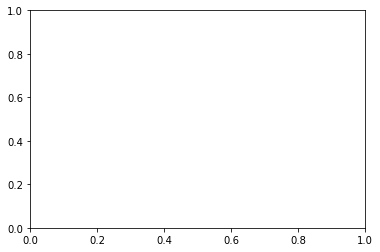

In [141]:
fig, ax = plt.subplots()

Can you set the x-axis locator (ticks) using dates class from matplotlib?
- set the major locator to days.
- set the minor locator to every 6 hours.
- set the x-axis formatter to Day-Month for each day.

In [142]:
# In the matplotlib.dates module, as mdates, look at the DayLocator and HourLocator.
fmt_day = mdates.DayLocator()
fmt_six_hours = mdates.HourLocator(interval=6)

ax.xaxis.set_major_locator(fmt_day)
ax.xaxis.set_minor_locator(fmt_six_hours)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

Label the axis, `ax`, on the plot:
- label the x-axis as `Date`
- label the y-axis as `Air Temperature / K`
- set a title on your plot

In [143]:
ax.set_xlabel("Date")
ax.set_ylabel("Air Temperature (K)")
ax.set_title("Air temperature Forecast")

Text(0.5, 1.0, 'Air temperature Forecast')

Open each NetCDF file and extract the `temp`, `time`, `lat` and `lon` variables from the file. Then use the matplotlib `plot_date` function to plot the graph.

- set the label of plot to the `<lat>, <lon>` coordinates attribute of the `temp` variable.

Replace the elipses with your plotting, the `for` loop works through all the shared NetCDF files in the workspace, where `f` is the file path and `filepaths` is a list of data files.

If you need help, look at the 'Plotting data with matplotlib' slide in the [logging data from serial ports](https://github.com/ncasuk/ncas-isc/raw/68abbfd3a573e576c32fc127fafc874bfff98b1e/python/presentations/logging-data-from-serial-ports/LDFSP_Slides.pdf) presentation.

Plot a line graph using matplotlib: 

- you will need to set the marker to `-` otherwise you will get a scatter graph.
- set the label of the plot to a string: `<lat>, <lon>`.

In [144]:
for f in filepaths:
    try:
        print(f)
        dset = Dataset(f, mode='r')
    
        temp = dset.variables['temp']
        time = dset.variables['time']
        lat = dset.variables['lat'][0]
        lon = dset.variables['lon'][0]

        times = num2date(time[:], units=time.units, calendar=time.calendar)
        ax.plot_date(times, temp[:], '-', label=f"{lat:.3f}, {lon:.3f}")
    except Exception as e:
        print(e)

/home/users/amanning/weather_exercise/TOP-train022-temps.nc
/home/users/amanning/weather_exercise/OUN-train033-temps.nc
/home/users/amanning/weather_exercise/GLD-train020-temps.nc
/home/users/amanning/weather_exercise/GLD-train024-temps.nc
/home/users/amanning/weather_exercise/BOU-train032-temps.nc
/home/users/amanning/weather_exercise/ICT-train028-temps.nc
/home/users/amanning/weather_exercise/BOU-train025-temps.nc
/home/users/amanning/weather_exercise/BOU-train029-temps.nc
'time'
/home/users/amanning/weather_exercise/TOP-train026-temps.nc
/home/users/amanning/weather_exercise/BOX-train038-temps.nc


Finally, show the plot with a legend, you might want to enable tight layout,
and save the plot to your `MY_DATA_DIR` directory.

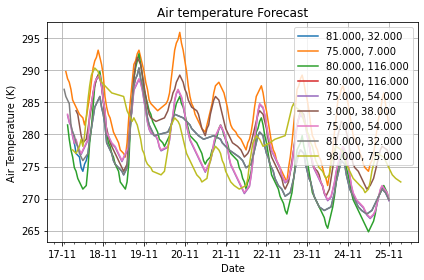

In [135]:
ax.grid(True)
fig.tight_layout()
ax.legend()
fig

### Save the graph to a PNG file

In [145]:
fig.savefig(f"{MY_DATA_DIR}/{gridID}-{USER}-temps.png")